In [1]:
import pyodbc
import yfinance as yf
import pandas as pd
from sqlalchemy import create_engine
import datetime
from datetime import date, timedelta

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Tabelle prüfen
table_name = "stock_data"  # Name der Zieltabelle
start_date = "2022-07-01"  # Startdatum, ab dem Daten überprüft werden sollen
end_date = "2023-07-01"  # Enddatum, bis zu dem Daten überprüft werden sollen
company_name = "GOOG"  # nur AAPL, MSFT oder GOOG möglich // Name des Unternehmens, für das Daten geladen werden sollen

# Daten aus der Tabelle für das bestimmte Unternehmen in einen DataFrame laden
select_query = f"SELECT * FROM {table_name} WHERE date >= ? AND date <= ? AND Company = ?"
data = pd.read_sql(select_query, con=engine, params=(start_date, end_date, company_name))

# added
data["ID"] = data.index
data = data[["ID", "Date", "Company", "Type", "Open", "High", "Low", "Close", "Volume"]]
data.reset_index(drop=True, inplace=True)

# Verbindung schließen
cnxn.close()

# DataFrame anzeigen
print(data.tail())


      ID       Date Company Type        Open        High         Low  \
246  246 2023-06-26    GOOG  ACT  121.466003  122.720001  118.989998   
247  247 2023-06-27    GOOG  ACT  117.839996  119.894997  116.910004   
248  248 2023-06-28    GOOG  ACT  117.959999  121.269997  117.599998   
249  249 2023-06-29    GOOG  ACT  120.089996  120.910004  119.209999   
250  250 2023-06-30    GOOG  ACT  121.099998  122.029999  120.879997   

          Close    Volume  
246  119.089996  23185000  
247  119.010002  27221700  
248  121.080002  19753100  
249  120.010002  18517500  
250  120.970001  23865800  


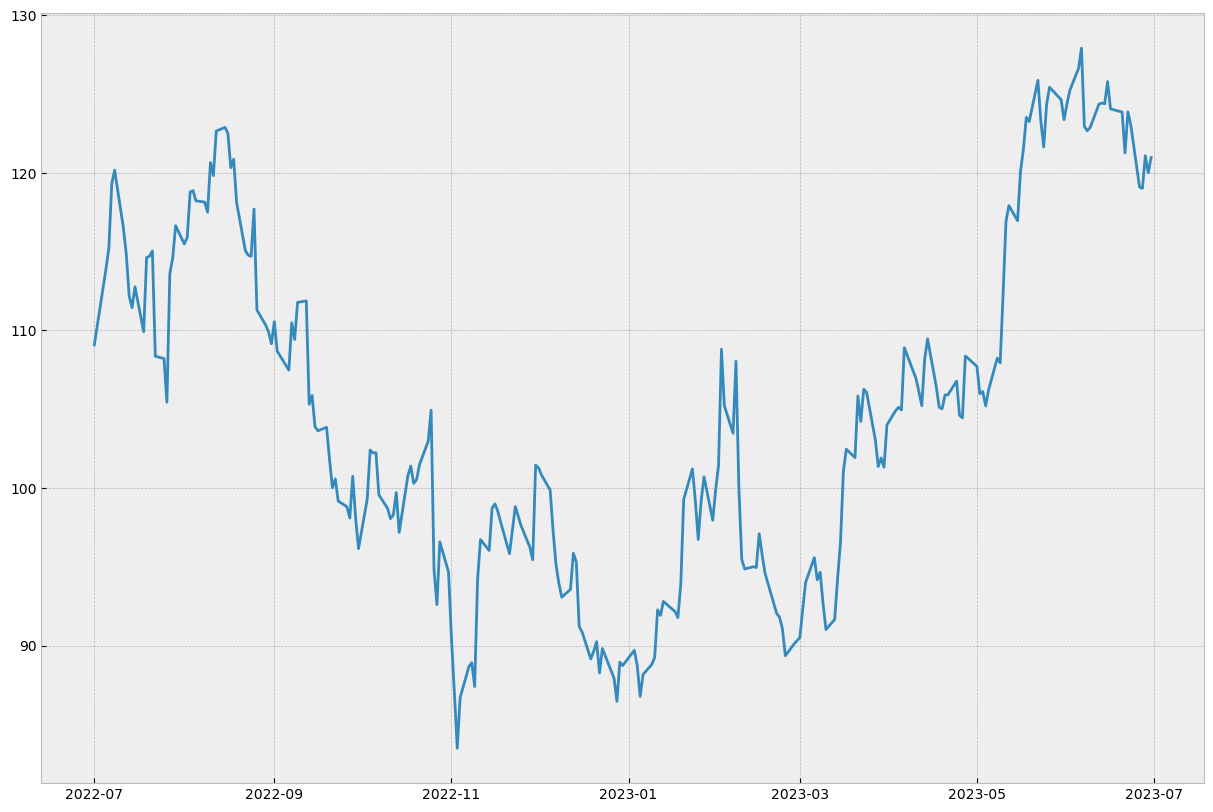

In [2]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

<Figure size 640x480 with 0 Axes>

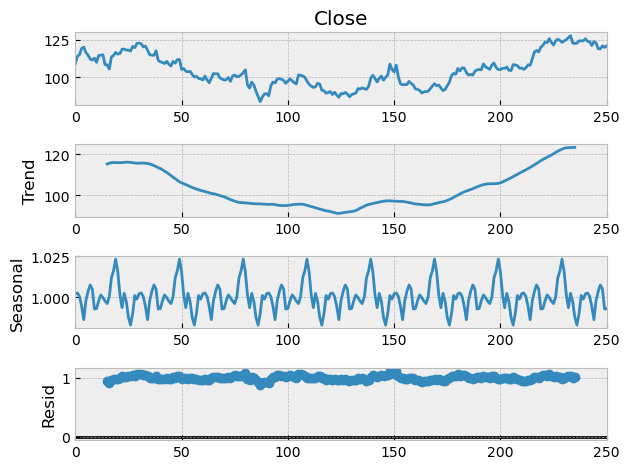

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"], model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot() 

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

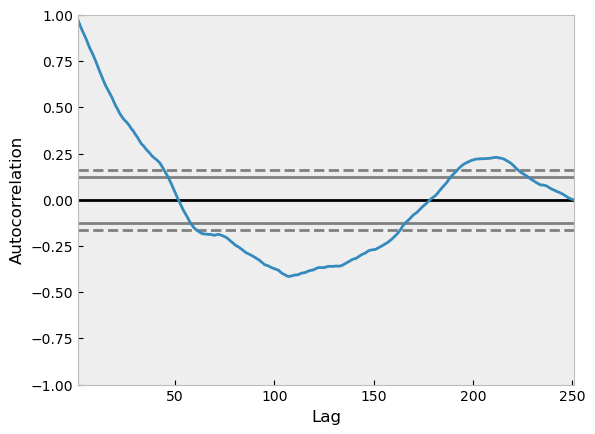

In [4]:
pd.plotting.autocorrelation_plot(data["Close"])

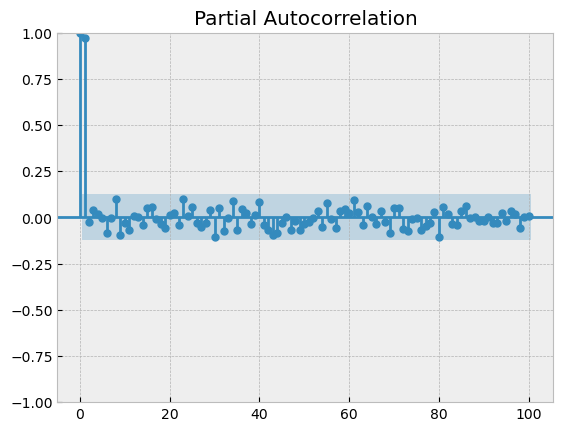

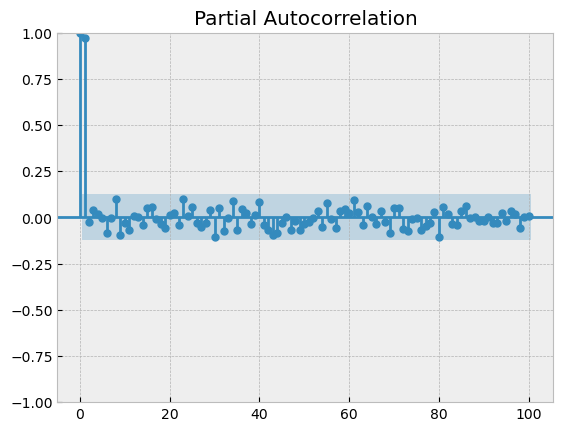

In [5]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data["Close"], lags=100, method='ywm')

In [6]:
p, d, q = 5, 1, 2
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data["Close"], order=(p,d,q))
fitted = model.fit()

print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  251
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -572.821
Date:                Sat, 08 Jul 2023   AIC                           1161.642
Time:                        22:15:02   BIC                           1189.813
Sample:                             0   HQIC                          1172.980
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1041      0.529      0.197      0.844      -0.932       1.140
ar.L2          0.8100      0.534      1.517      0.129      -0.237       1.857
ar.L3         -0.0230      0.098     -0.235      0.8

C:\Users\HerbyHerb\.conda\envs\tf_new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
predictions = fitted.predict()
print(predictions)

0        0.000000
1      109.081005
2      113.914522
3      114.843434
4      119.094164
          ...    
246    122.690505
247    118.893997
248    119.220785
249    120.980658
250    119.709078
Name: predicted_mean, Length: 251, dtype: float64


In [8]:
import statsmodels.api as sm
import warnings
import time

# Startzeit messen
start_time = time.time()

model = sm.tsa.statespace.SARIMAX(data['Close'],
                                 order=(p, d, q),
                                 seasonal_order=(p, d, q, 12))
model = model.fit()

# Endzeit messen
end_time = time.time()

# Gesamtdauer berechnen
duration = end_time - start_time

print(model.summary())
print("Durchlaufdauer:", duration, "Sekunden")

C:\Users\HerbyHerb\.conda\envs\tf_new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\HerbyHerb\.conda\envs\tf_new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\HerbyHerb\.conda\envs\tf_new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  251
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood                -560.115
Date:                            Sat, 08 Jul 2023   AIC                           1150.230
Time:                                    22:15:20   BIC                           1202.314
Sample:                                         0   HQIC                          1171.221
                                            - 251                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6618      0.189     -3.509      0.000      -1.031      -0.292
ar.L2         -0.9773      0.164   

In [9]:
predictions = model.predict(len(data), len(data)+30)
print(predictions)

251    122.109786
252    123.035942
253    123.228575
254    123.920444
255    123.816750
256    123.414830
257    122.690735
258    122.712645
259    123.582930
260    123.913962
261    124.184511
262    124.458878
263    125.822884
264    128.086592
265    127.635166
266    127.428120
267    127.739569
268    128.389525
269    128.894936
270    127.760345
271    128.421155
272    128.102148
273    128.324522
274    128.793524
275    129.400480
276    129.915375
277    129.098398
278    130.062179
279    129.687673
280    130.125415
281    129.709910
Name: predicted_mean, dtype: float64


<Axes: >

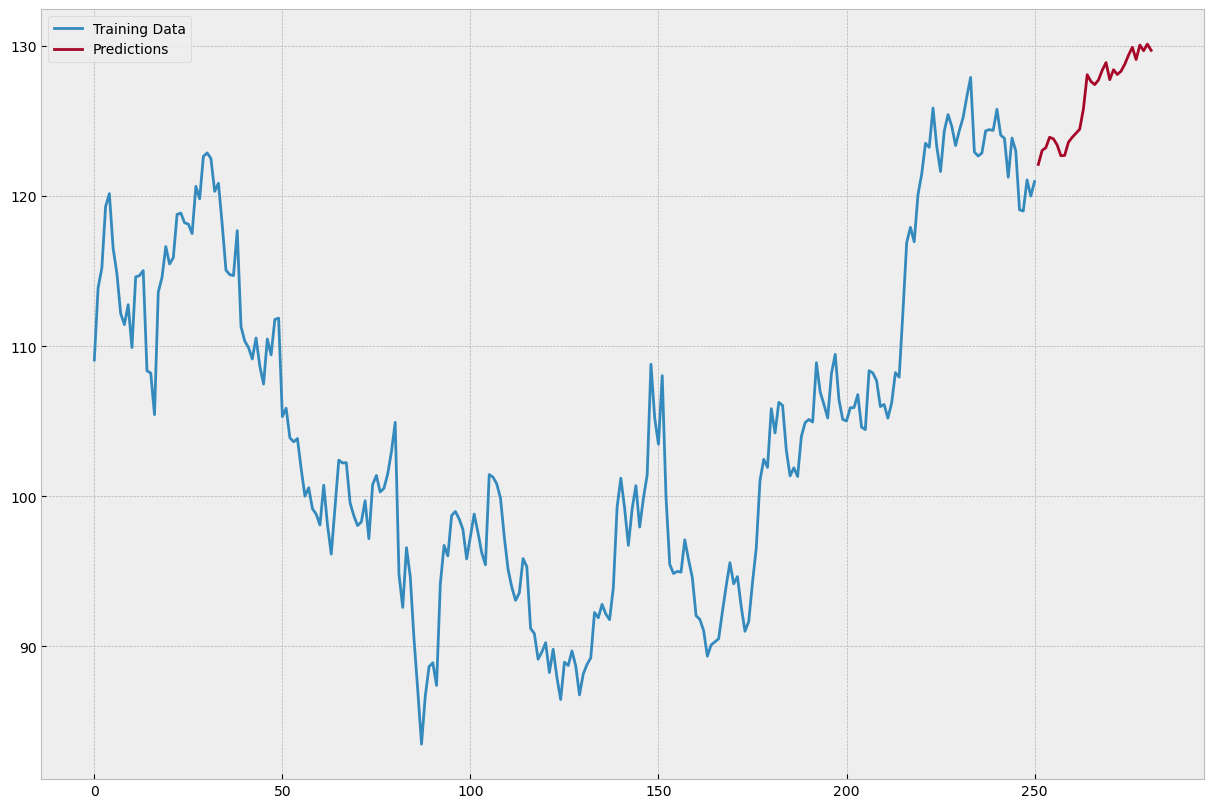

In [10]:
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")

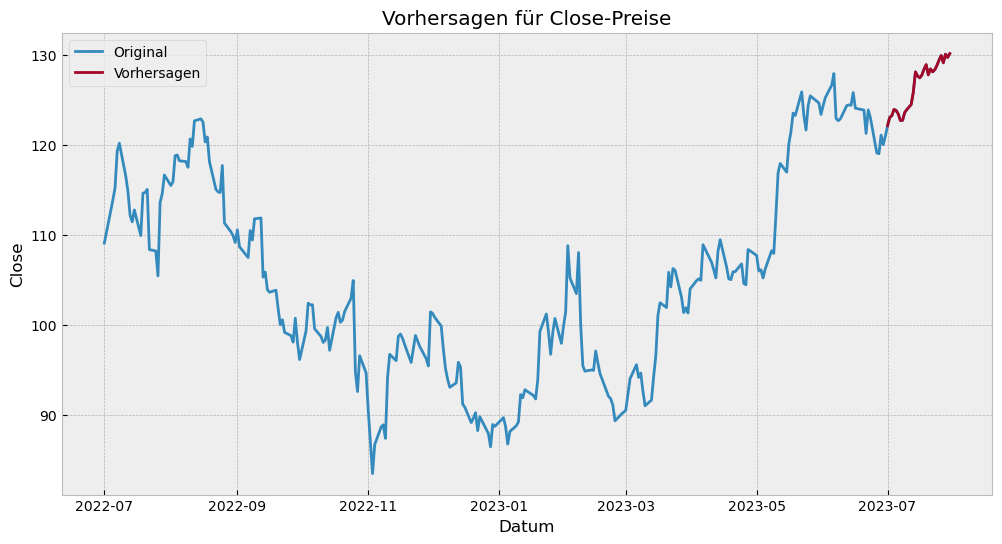

In [11]:
# Vorhersagen für die nächsten 30 Tage erhalten
predictions = model.predict(len(data), len(data) + 29)  # 30 Tage Vorhersagen

# Daten für die nächsten 30 Tage generieren
future_dates = pd.date_range(start=data['Date'].iloc[-1] + timedelta(days=1), periods=30)

# Ein DataFrame für die Vorhersagen erstellen
df_predictions = pd.DataFrame({
    'Date': future_dates,
    'Close': predictions
})

# DataFrame erweitern, indem Sie die Vorhersagen anhängen
data_extended = pd.concat([data, df_predictions])

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(data_extended['Date'], data_extended['Close'], label='Original')
plt.plot(data_extended['Date'].tail(30), data_extended['Close'].tail(30), label='Vorhersagen')
plt.xlabel('Datum')
plt.ylabel('Close')
plt.title('Vorhersagen für Close-Preise')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
data_extended_key = data_extended

In [13]:
import numpy as np

# Key einbinden
company = data.loc[0]['Company']
data_extended_key['Company'] = company
data_extended_key['Type'] = data_extended_key['High'].apply(lambda x: f'Arima_{company}' if np.isnan(x) else f'Act_{company}')
data_extended_key.loc[data_extended_key['Type'].str.contains('Arima'), 'Forecast_Date'] = end_date
data_extended_key['Key'] = data_extended_key['Company'] + '_' + data_extended_key['Date'].astype(str) + '_' + data_extended_key['Type']


In [14]:
import pyodbc
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import warnings

# Deaktivieren der Pandas-Warnungen
warnings.filterwarnings('ignore', category=UserWarning)

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Query erstellen, um alle Daten auszulesen
query = "SELECT * FROM stock_data_forecast"

# Ausführen der Query und Laden der Ergebnisse in einen DataFrame
exists_df = pd.read_sql(query, cnxn)

# added
exists_df = exists_df.astype(data_extended.dtypes)
exists_df = exists_df.reindex(columns=data_extended.columns)

# Key einbinden
exists_df['Key'] = exists_df['Company'] + '_' + exists_df['Date'].astype(str) + '_' + exists_df['Type']

In [15]:
# Zusammenführen der beiden DataFrames
combined_df = pd.concat([exists_df, data_extended_key])



In [16]:
# Entfernen von Duplikaten
combined_df = combined_df.drop_duplicates(subset=['Key'], keep=False)

In [17]:
# Schreiben des aktualisierten DataFrames in die SQL Server-Tabelle
combined_df.to_sql('stock_data_forecast', con=engine, if_exists='append', index=False)

# Anzahl der geschriebenen Zeilen erhalten
num_written_rows = combined_df.shape[0]
print(f"Es wurden {num_written_rows} Zeilen erfolgreich übertragen.")

exists_df = pd.read_sql('SELECT * FROM stock_data_forecast', cnxn)
exists_df.drop_duplicates(subset='Key', inplace=True)

# Verbindung schließen
cnxn.close()
print(f"Die Verbindung ist wieder geschlossen.")

Es wurden 121 Zeilen erfolgreich übertragen.
Die Verbindung ist wieder geschlossen.
